In [15]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Load datasets (monthly or converted to monthly frequency)
cpi_df = pd.read_csv('CPI.csv')       # Consumer Price Index (monthly index values)
gdp_df = pd.read_csv('GDP.csv')       # Gross Domestic Product (annual, will distribute to monthly)
res_df = pd.read_csv('RESERVE.csv')  # Foreign reserves (annual, will interpolate to monthly)
ca_df  = pd.read_csv('CA.csv')        # Current account balance (quarterly, will distribute to monthly)
fdi_df = pd.read_csv('FDI.csv')       # Foreign investment flows (annual, will distribute to monthly)
uk_ir_df = pd.read_csv('UK_IR.csv')   # Bank of England interest rate changes (dates and rates)
er_df   = pd.read_csv('ER:USD.csv')   # Exchange rates (GBP/USD and CNY/USD)
china_ir_df = pd.read_csv('China_IR.csv')

In [3]:
# Step 1: 统一命名
uk_ir_df.columns = ['Date Changed', 'Rate']

# Step 2: 解析日期字符串：'08 May 25' ➜ datetime(2025, 5, 8)
def parse_date_custom(datestr):
    try:
        return pd.to_datetime(datestr, format='%d %b %y')
    except:
        return pd.NaT

uk_ir_df['Date Changed'] = uk_ir_df['Date Changed'].apply(parse_date_custom)
uk_ir_df.dropna(subset=['Date Changed'], inplace=True)
uk_ir_df.sort_values('Date Changed', inplace=True)



In [4]:
# Step 3: 构建完整的月度时间序列（2010-01 到 2024-12）
monthly_index = pd.date_range('2010-01-01', '2024-12-31', freq='M')
monthly_rates = pd.Series(index=monthly_index, dtype=float)

# Step 4: 填充每个月的利率（最近一次已知变动）
current_rate = None
change_index = 0
for date in monthly_index:
    while change_index < len(uk_ir_df) and uk_ir_df.iloc[change_index]['Date Changed'] <= date:
        current_rate = uk_ir_df.iloc[change_index]['Rate']
        change_index += 1
    monthly_rates[date] = current_rate

# Step 5: 若最前面是NaN（即2010年前无数据），手动填上第一个值
monthly_rates.ffill(inplace=True)  # 向前填充

# 现在你得到了完整的月度 UK 利率序列
uk_rate_monthly = monthly_rates


/var/folders/nb/lml3l_ls6b7gzy20lpv559vh0000gn/T/ipykernel_14432/3262586031.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_index = pd.date_range('2010-01-01', '2024-12-31', freq='M')


In [5]:
cn_ir_df = pd.read_csv('China_IR.csv')
cn_ir_df

,China_PolicyRate_2004_2025_estimated
NaN,NaN
2004-11-01,5.58
2004-12-01,5.58
2005-01-01,5.58
2005-02-01,5.58
...,...
2024-12-01,3.10
2025-01-01,3.10
2025-02-01,3.10
2025-03-01,3.10


In [6]:
# 使用你已经处理好的英国利率 uk_rate_monthly
interest_diff = uk_rate_monthly - cn_ir_df


In [7]:
# Filter CPI data for UK and China and compute ratio (Purchasing Power Parity approximation)
cpi_cn = cpi_df[cpi_df['COUNTRY']=="China, People's Republic of"].iloc[0]
cpi_uk = cpi_df[cpi_df['COUNTRY']=="United Kingdom"].iloc[0]
monthly_cols = [col for col in cpi_df.columns if re.match(r'\d{4}-M\d{2}', str(col))]
# Select monthly columns from 2010-01 through 2024-12 (past 15 years)
start_idx = monthly_cols.index('2010-M01'); end_idx = monthly_cols.index('2024-M12')
mon_range = monthly_cols[start_idx:end_idx+1]
cpi_cn_series = cpi_cn[mon_range].astype(float).reset_index(drop=True)
cpi_uk_series = cpi_uk[mon_range].astype(float).reset_index(drop=True)
cpi_ratio = cpi_cn_series / cpi_uk_series  # CPI ratio (China/UK) for PPP

# Process UK interest rates: create a monthly series from BoE rate change log
uk_ir_df['Date Changed'] = pd.to_datetime(uk_ir_df['Date Changed'])
uk_ir_df.sort_values('Date Changed', inplace=True)
dates = pd.date_range('2010-01-01', '2024-12-31', freq='M')  # monthly period over 15 years
uk_rate_monthly = []
current_rate = None; change_idx = 0
for d in dates:
    # If a rate change happened on or before this date, update current_rate
    while change_idx < len(uk_ir_df) and uk_ir_df.iloc[change_idx]['Date Changed'] <= d:
        current_rate = uk_ir_df.iloc[change_idx]['Rate']
        change_idx += 1
    uk_rate_monthly.append(current_rate)
uk_rate_monthly = pd.Series(uk_rate_monthly, index=dates)
# Fill initial months with last known pre-2010 rate (forward-fill)
if pd.isna(uk_rate_monthly.iloc[0]):
    last_pre2010 = uk_ir_df[uk_ir_df['Date Changed'] < dates[0]].iloc[-1]['Rate']
    uk_rate_monthly.iloc[0] = last_pre2010
uk_rate_monthly.fillna(method='ffill', inplace=True)

# Process China interest rates: use known benchmark rates (Interest Rate Parity approximation)
# (Assume: 2.79% until Nov 2010, 3.25% from Dec 2010 to Oct 2015, 2.90% from Nov 2015 onward)
cn_rate_monthly = []
for d in dates:
    if d < pd.Timestamp('2010-12-01'):
        cn_rate_monthly.append(2.79)
    elif d < pd.Timestamp('2015-11-01'):
        cn_rate_monthly.append(3.25)
    else:
        cn_rate_monthly.append(2.90)
cn_rate_monthly = pd.Series(cn_rate_monthly, index=dates)

# Interest rate differential (UK - China) for IRP
interest_diff = uk_rate_monthly - cn_rate_monthly

# Distribute annual GDP to monthly (assume equal monthly share of annual GDP)
gdp_cn_row = gdp_df[gdp_df['COUNTRY']=="China, People's Republic of"].iloc[0]
gdp_uk_row = gdp_df[gdp_df['COUNTRY']=="United Kingdom"].iloc[0]
years = range(2010, 2025)
gdp_cn_monthly = []; gdp_uk_monthly = []
for year in years:
    annual_cn = float(gdp_cn_row[str(year)]); annual_uk = float(gdp_uk_row[str(year)])
    # Divide annual GDP (billions USD) evenly into 12 months
    gdp_cn_monthly.extend([annual_cn/12.0]*12)
    gdp_uk_monthly.extend([annual_uk/12.0]*12)
# Trim to match the exact date range length
gdp_cn_monthly = pd.Series(gdp_cn_monthly[:len(dates)], index=dates)
gdp_uk_monthly = pd.Series(gdp_uk_monthly[:len(dates)], index=dates)

# Interpolate foreign reserves (annual USD values) to monthly
res_cn_row = res_df[res_df['Country Name']=="China"].iloc[0]
res_uk_row = res_df[res_df['Country Name']=="United Kingdom"].iloc[0]
# Create a dictionary of year-end values
res_cn_vals = {int(col[:4]): res_cn_row[col] for col in res_df.columns if col.startswith('20')}
res_uk_vals = {int(col[:4]): res_uk_row[col] for col in res_df.columns if col.startswith('20')}
# Fill missing years by linear interpolation
for year in range(2000, 2025):
    if year not in res_cn_vals or pd.isna(res_cn_vals[year]):
        # find nearest known previous and next year values
        prev_y = year - 1; next_y = year + 1
        while prev_y >= 2000 and (prev_y not in res_cn_vals or pd.isna(res_cn_vals[prev_y])):
            prev_y -= 1
        while next_y <= 2024 and (next_y not in res_cn_vals or pd.isna(res_cn_vals[next_y])):
            next_y += 1
        if prev_y >= 2000 and next_y <= 2024:
            # linear interpolate between prev_y and next_y
            res_cn_vals[year] = res_cn_vals[prev_y] + (res_cn_vals[next_y] - res_cn_vals[prev_y]) * ((year - prev_y) / (next_y - prev_y))
            res_uk_vals[year] = res_uk_vals[prev_y] + (res_uk_vals[next_y] - res_uk_vals[prev_y]) * ((year - prev_y) / (next_y - prev_y))
# Create monthly series by interpolating between year-end values
res_cn_monthly = []; res_uk_monthly = []
for year in range(2010, 2025):
    prev_val_cn = res_cn_vals.get(year-1, res_cn_vals.get(year))
    prev_val_uk = res_uk_vals.get(year-1, res_uk_vals.get(year))
    curr_val_cn = res_cn_vals.get(year); curr_val_uk = res_uk_vals.get(year)
    if prev_val_cn is None or curr_val_cn is None:
        prev_val_cn = curr_val_cn = res_cn_vals.get(year)
        prev_val_uk = curr_val_uk = res_uk_vals.get(year)
    # Linearly interpolate each month of this year from prev year-end to current year-end value
    for m in range(1, 13):
        frac = m / 12.0
        res_cn_monthly.append(prev_val_cn + frac * (curr_val_cn - prev_val_cn))
        res_uk_monthly.append(prev_val_uk + frac * (curr_val_uk - prev_val_uk))
res_cn_monthly = pd.Series(res_cn_monthly[:len(dates)], index=dates)
res_uk_monthly = pd.Series(res_uk_monthly[:len(dates)], index=dates)

# Distribute quarterly current account data to monthly (equal share per month of quarter)
ca_cn_row = ca_df[ca_df['COUNTRY']=="China, People's Republic of"].iloc[0]
ca_uk_row = ca_df[ca_df['COUNTRY']=="United Kingdom"].iloc[0]
ca_cn_monthly = []; ca_uk_monthly = []
for year in range(2010, 2025):
    for q in range(1, 5):
        col = f"{year}-Q{q}"
        if col in ca_cn_row and not pd.isna(ca_cn_row[col]):
            # take the quarterly balance (in millions USD)
            val_cn_q = float(ca_cn_row[col]); val_uk_q = float(ca_uk_row[col])
        else:
            # if data missing (beyond available range), assume 0
            val_cn_q = 0.0; val_uk_q = 0.0
        # assign one-third of quarterly value to each month in the quarter
        ca_cn_monthly.extend([val_cn_q/3.0]*3)
        ca_uk_monthly.extend([val_uk_q/3.0]*3)
ca_cn_monthly = pd.Series(ca_cn_monthly[:len(dates)], index=dates)
ca_uk_monthly = pd.Series(ca_uk_monthly[:len(dates)], index=dates)

# Distribute annual investment flows (FDI/portfolio) to monthly (equal monthly flow)
fdi_cn_row = fdi_df[fdi_df['COUNTRY']=="China, People's Republic of"].iloc[0]
fdi_uk_row = fdi_df[fdi_df['COUNTRY']=="United Kingdom"].iloc[0]
fdi_cn_monthly = []; fdi_uk_monthly = []
for year in range(2010, 2025):
    if str(year) in fdi_cn_row and not pd.isna(fdi_cn_row[str(year)]):
        val_cn_y = float(fdi_cn_row[str(year)]); val_uk_y = float(fdi_uk_row[str(year)])
    else:
        # if 2024 not available, use last known (2023) as estimate
        val_cn_y = float(fdi_cn_row['2023']); val_uk_y = float(fdi_uk_row['2023'])
    fdi_cn_monthly.extend([val_cn_y/12.0]*12)
    fdi_uk_monthly.extend([val_uk_y/12.0]*12)
fdi_cn_monthly = pd.Series(fdi_cn_monthly[:len(dates)], index=dates)
fdi_uk_monthly = pd.Series(fdi_uk_monthly[:len(dates)], index=dates)

# Derive CNY/GBP exchange rate from USD exchange rates (target variable)
# (CNY/GBP = (CNY/USD) / (GBP/USD))
uk_er_pa = er_df[(er_df['COUNTRY']=="United Kingdom") & (er_df['TYPE_OF_TRANSFORMATION']=="Period average")].iloc[0]
cn_er_pa = er_df[(er_df['COUNTRY']=="China, People's Republic of") & (er_df['TYPE_OF_TRANSFORMATION']=="Period average")].iloc[0]
er_monthly_cols = [col for col in er_df.columns if re.match(r'\d{4}-M\d{2}', str(col))]
er_start = er_monthly_cols.index('2010-M01'); er_end = er_monthly_cols.index('2024-M12')
er_range = er_monthly_cols[er_start:er_end+1]
# Get monthly average exchange rates for GBP/USD and CNY/USD
gbp_per_usd = uk_er_pa[er_range].astype(float).reset_index(drop=True)  # GBP per 1 USD
cny_per_usd = cn_er_pa[er_range].astype(float).reset_index(drop=True)  # CNY per 1 USD
cny_per_gbp = cny_per_usd / gbp_per_usd  # CNY per 1 GBP

# Compile all features and target into a single DataFrame
data = pd.DataFrame({
    'Interest_Diff': interest_diff.values,   # interest rate differential (UK - CN)
    'CPI_Ratio': cpi_ratio.values,           # CPI ratio (CN/UK)
    'GDP_UK': gdp_uk_monthly.values,
    'GDP_CN': gdp_cn_monthly.values,
    'Reserves_UK': res_uk_monthly.values,
    'Reserves_CN': res_cn_monthly.values,
    'CA_UK': ca_uk_monthly.values,
    'CA_CN': ca_cn_monthly.values,
    'FDI_UK': fdi_uk_monthly.values,
    'FDI_CN': fdi_cn_monthly.values,
    'Exchange': cny_per_gbp.values  # target variable
}, index=dates)

# Feature: previous month's exchange rate (to capture momentum/autocorrelation)
data['Prev_Exchange'] = data['Exchange'].shift(1)
# Fill the first month's previous exchange using Dec 2009 value (from data prior to 2010)
if '2009-M12' in cn_er_pa and '2009-M12' in uk_er_pa:
    prev_dec_2009 = float(cn_er_pa['2009-M12'] / uk_er_pa['2009-M12'])
    data.at[dates[0], 'Prev_Exchange'] = prev_dec_2009

# Drop any rows with NaNs (if any at start)
data.dropna(inplace=True)
# Now `data` contains all features and the target, aligned monthly from 2010-01 to 2024-12.
data['Interest_Diff'] = interest_diff.loc[data.index]


/var/folders/nb/lml3l_ls6b7gzy20lpv559vh0000gn/T/ipykernel_14432/3888920688.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range('2010-01-01', '2024-12-31', freq='M')  # monthly period over 15 years
/var/folders/nb/lml3l_ls6b7gzy20lpv559vh0000gn/T/ipykernel_14432/3888920688.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uk_rate_monthly.fillna(method='ffill', inplace=True)


In [8]:
data

,Interest_Diff,CPI_Ratio,GDP_UK,GDP_CN,Reserves_UK,Reserves_CN,CA_UK,CA_CN,FDI_UK,FDI_CN,Exchange,Prev_Exchange
2010-01-31,-2.29,0.867147,207.327000,511.582667,9.604719e+10,2.030450e+12,-5219.215952,8331.801483,-7926.415577,-2003.203523,11.040747,11.088963
2010-02-28,-2.29,0.875631,207.327000,511.582667,9.678046e+10,2.049814e+12,-5219.215952,8331.801483,-7926.415577,-2003.203523,10.662021,11.040747
2010-03-31,-2.29,0.865566,207.327000,511.582667,9.751373e+10,2.069177e+12,-5219.215952,8331.801483,-7926.415577,-2003.203523,10.271684,10.662021
2010-04-30,-2.29,0.862509,207.327000,511.582667,9.824700e+10,2.088541e+12,-3929.161561,14588.056831,-7926.415577,-2003.203523,10.460919,10.271684
2010-05-31,-2.29,0.859753,207.327000,511.582667,9.898027e+10,2.107904e+12,-3929.161561,14588.056831,-7926.415577,-2003.203523,9.989207,10.460919
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,2.10,0.778111,303.719667,1562.334083,1.583514e+11,3.326384e+12,-7962.078206,52478.834099,18661.784208,5270.342530,9.240400,9.345691
2024-09-30,2.10,0.777528,303.719667,1562.334083,1.559059e+11,3.310989e+12,-7962.078206,52478.834099,18661.784208,5270.342530,9.354027,9.240400
2024-10-31,2.10,0.771407,303.719667,1562.334083,1.534604e+11,3.295594e+12,-5993.368946,54591.856908,18661.784208,5270.342530,9.276146,9.354027
2024-11-30,1.85,0.765230,303.719667,1562.334083,1.510149e+11,3.280199e+12,-5993.368946,54591.856908,18661.784208,5270.342530,9.186692,9.276146


In [9]:
# Split data into training and testing sets (e.g., train: 2010-01 to 2022-12, test: 2023-01 to 2024-12)
split_date = pd.Timestamp('2023-01-31')  # end of Jan 2023 marks beginning of test period
train_df = data[:split_date]   # up to Dec 2022
test_df = data[split_date:]    # 2023-01 through 2024-12

# Separate features (X) and target (y)
X_train = train_df.drop(columns=['Exchange'])
y_train = train_df['Exchange']
X_test = test_df.drop(columns=['Exchange'])
y_test = test_df['Exchange']

# Normalize features and target using Min-Max scaling (fit on training data only)
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

# Prepare data for LSTM: create sequences of length `lookback` for each training example
lookback = 12  # use past 12 months to predict the next month
X_train_seq, y_train_seq = [], []
for i in range(lookback, len(X_train_scaled)):
    # sequence of `lookback` feature vectors
    X_train_seq.append(X_train_scaled[i-lookback:i])
    # target is the exchange rate at this time (one month ahead of last input month)
    y_train_seq.append(y_train_scaled[i])
X_train_seq = np.array(X_train_seq)
y_train_seq = np.array(y_train_seq)

# Prepare sequences for the test set (using preceding data for initial sequence)
X_test_seq, y_test_seq = [], []
# Concatenate train and test for sequence generation to include trailing train data in initial test sequences
total_X = np.concatenate((X_train_scaled, X_test_scaled), axis=0)
total_y = np.concatenate((y_train_scaled, y_test_scaled), axis=0)
train_len = len(X_train_scaled)
for i in range(train_len, len(total_X)):
    if i < lookback:
        continue  # skip until we have enough history
    X_test_seq.append(total_X[i-lookback:i])
    y_test_seq.append(total_y[i])
X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq)

# Build the LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
# 改进后的双层 LSTM 架构
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(lookback, X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(1))

# 别忘了这一步！！
model.compile(optimizer='adam', loss='mean_squared_error')

# 然后再训练
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_split=0.1, verbose=1)


/Users/loki/PycharmProjects/PythonProject5/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch 1/50


/Users/loki/PycharmProjects/PythonProject5/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1241 - val_loss: 0.1102
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0282 - val_loss: 0.0053
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0200 - val_loss: 0.0205
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0171 - val_loss: 0.0032
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0138 - val_loss: 0.0127
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0127 - val_loss: 0.0131
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 - val_loss: 0.0093
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103 - val_loss: 0.0122
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091 - val_loss: 0.0220
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094 - val_loss: 0.0204
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0111 - val_loss: 0.0134
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0093 - val_loss: 0.0250
Epoch 13/50
9/9 ━━━━━━━

Test MSE Loss: 0.094685
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


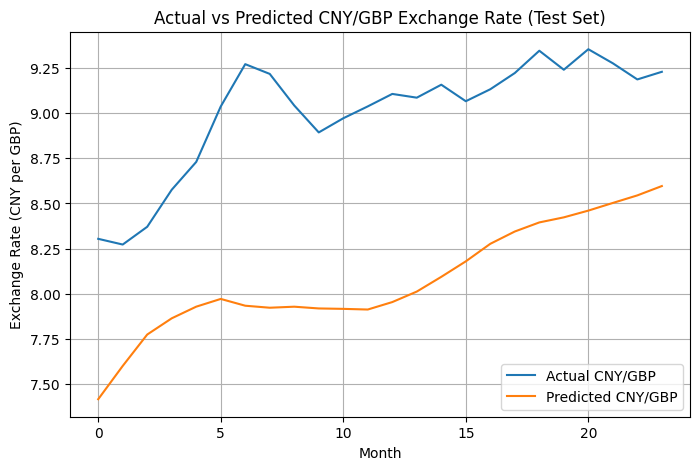

In [10]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Test MSE Loss: {test_loss:.6f}")

# Make predictions for the test period
y_pred_scaled = model.predict(X_test_seq)
# Inverse-transform the predictions back to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_actual = target_scaler.inverse_transform(y_test_seq)

# Visualize the results: Actual vs Predicted exchange rate

plt.figure(figsize=(8,5))
plt.plot(y_actual, label='Actual CNY/GBP')
plt.plot(y_pred, label='Predicted CNY/GBP')
plt.title('Actual vs Predicted CNY/GBP Exchange Rate (Test Set)')
plt.xlabel('Month')
plt.ylabel('Exchange Rate (CNY per GBP)')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.layers import GlobalAveragePooling1D

from sklearn.metrics import mean_squared_error




Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2742 - val_loss: 0.1099
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451 - val_loss: 0.1787
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0406 - val_loss: 0.0479
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0338 - val_loss: 0.0731
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0235 - val_loss: 0.0604
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0256 - val_loss: 0.0369
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0373 - val_loss: 0.0506
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201 - val_loss: 0.0492
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204 - val_loss: 0.0469
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 - val_loss: 0.0651
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203 - val_loss: 0.0525
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170 - val_loss: 0.0472
Epoch 13/50


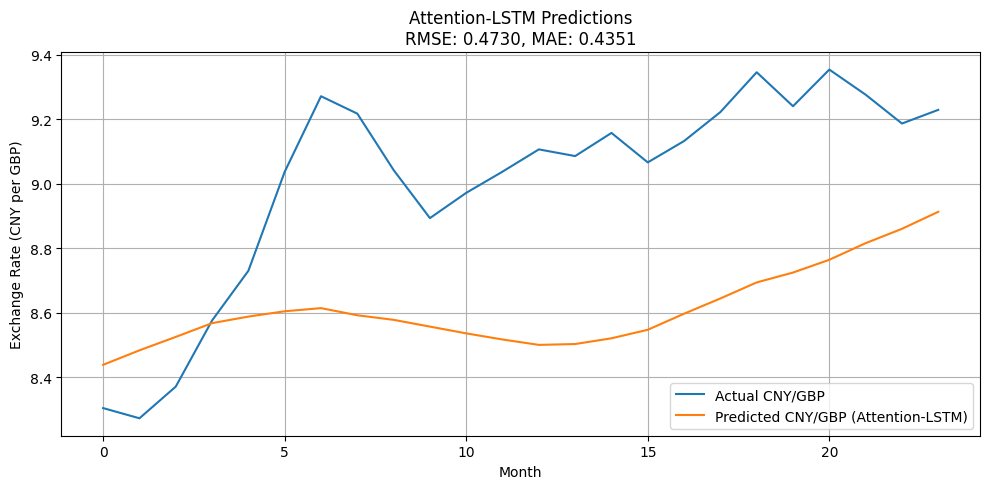

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention
# --- Normalize and create sequences ---
X_all = data.drop(columns='Exchange').values
y_all = data['Exchange'].values.reshape(-1, 1)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X_all)
y_scaled = scaler_y.fit_transform(y_all)

lookback = 12
X_seq, y_seq = [], []
for i in range(lookback, len(X_scaled)):
    X_seq.append(X_scaled[i-lookback:i])
    y_seq.append(y_scaled[i])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# --- Train-test split ---
split_index = -24
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]


input_layer = Input(shape=(lookback, X_seq.shape[2]))
lstm_out = LSTM(64, return_sequences=True)(input_layer)
attention = Attention()([lstm_out, lstm_out])
context_vector = GlobalAveragePooling1D()(attention)  # ← 修改点
dense1 = Dense(32, activation='relu')(context_vector)
drop1 = Dropout(0.2)(dense1)
output = Dense(1)(drop1)


model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# --- Train model ---
history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_split=0.1, verbose=1)

# --- Predict and evaluate ---
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)

import numpy as np

# y_actual, y_pred 是 NumPy 数组
rmse = np.sqrt(np.mean((y_actual - y_pred)**2))
mae = np.mean(np.abs(y_actual - y_pred))

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


# --- Plot predictions ---
plt.figure(figsize=(10, 5))
plt.plot(y_actual, label='Actual CNY/GBP')
plt.plot(y_pred, label='Predicted CNY/GBP (Attention-LSTM)')
plt.title(f'Attention-LSTM Predictions\nRMSE: {rmse:.4f}, MAE: {mae:.4f}')
plt.xlabel('Month')
plt.ylabel('Exchange Rate (CNY per GBP)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
data

,Interest_Diff,CPI_Ratio,GDP_UK,GDP_CN,Reserves_UK,Reserves_CN,CA_UK,CA_CN,FDI_UK,FDI_CN,Exchange,Prev_Exchange
2010-01-31,-2.29,0.867147,207.327000,511.582667,9.604719e+10,2.030450e+12,-5219.215952,8331.801483,-7926.415577,-2003.203523,11.040747,11.088963
2010-02-28,-2.29,0.875631,207.327000,511.582667,9.678046e+10,2.049814e+12,-5219.215952,8331.801483,-7926.415577,-2003.203523,10.662021,11.040747
2010-03-31,-2.29,0.865566,207.327000,511.582667,9.751373e+10,2.069177e+12,-5219.215952,8331.801483,-7926.415577,-2003.203523,10.271684,10.662021
2010-04-30,-2.29,0.862509,207.327000,511.582667,9.824700e+10,2.088541e+12,-3929.161561,14588.056831,-7926.415577,-2003.203523,10.460919,10.271684
2010-05-31,-2.29,0.859753,207.327000,511.582667,9.898027e+10,2.107904e+12,-3929.161561,14588.056831,-7926.415577,-2003.203523,9.989207,10.460919
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,2.10,0.778111,303.719667,1562.334083,1.583514e+11,3.326384e+12,-7962.078206,52478.834099,18661.784208,5270.342530,9.240400,9.345691
2024-09-30,2.10,0.777528,303.719667,1562.334083,1.559059e+11,3.310989e+12,-7962.078206,52478.834099,18661.784208,5270.342530,9.354027,9.240400
2024-10-31,2.10,0.771407,303.719667,1562.334083,1.534604e+11,3.295594e+12,-5993.368946,54591.856908,18661.784208,5270.342530,9.276146,9.354027
2024-11-30,1.85,0.765230,303.719667,1562.334083,1.510149e+11,3.280199e+12,-5993.368946,54591.856908,18661.784208,5270.342530,9.186692,9.276146


Epoch 1/50


/Users/loki/PycharmProjects/PythonProject5/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5788 - val_loss: 0.5243
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1171 - val_loss: 0.0393
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0424 - val_loss: 0.0068
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0294 - val_loss: 0.0508
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0206 - val_loss: 0.0036
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0170 - val_loss: 0.0085
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0140 - val_loss: 0.0141
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0153 - val_loss: 0.0070
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0132 - val_loss: 0.0110
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0115 - val_loss: 0.0133
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0114 - val_loss: 0.0056
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118 - val_loss: 0.0139
Epoch 13/50
8/8 ━━━━━━━

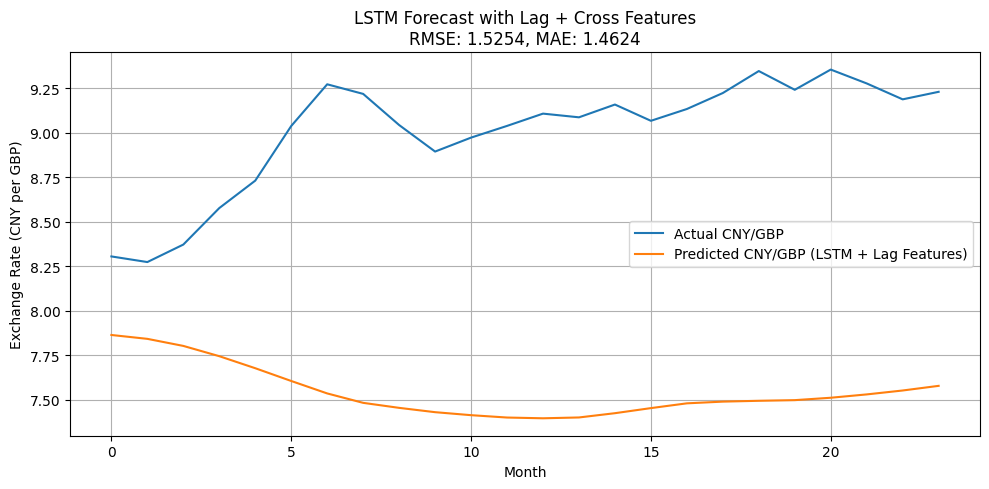

In [14]:

# --- Step 2: Add lag and interaction features ---
lags = [1, 3]
for col in ['Interest_Diff', 'CPI_Ratio', 'GDP_UK', 'GDP_CN', 'Reserves_UK', 'Reserves_CN']:
    for lag in lags:
        data[f'{col}_lag{lag}'] = data[col].shift(lag)

for lag in lags:
    data[f'IRxCPI_lag{lag}'] = data[f'Interest_Diff_lag{lag}'] * data[f'CPI_Ratio_lag{lag}']
    data[f'GDP_diff_lag{lag}'] = data[f'GDP_CN_lag{lag}'] - data[f'GDP_UK_lag{lag}']

data.dropna(inplace=True)

# --- Step 3: Prepare sequences ---
X_all = data.drop(columns=['Exchange']).values
y_all = data['Exchange'].values.reshape(-1, 1)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X_all)
y_scaled = scaler_y.fit_transform(y_all)

lookback = 12
X_seq, y_seq = [], []
for i in range(lookback, len(X_scaled)):
    X_seq.append(X_scaled[i-lookback:i])
    y_seq.append(y_scaled[i])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# --- Step 4: Train/test split ---
split_index = -24
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

# --- Step 5: Build and train LSTM model ---
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(lookback, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# --- Step 6: Evaluate and plot ---
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)

rmse = np.sqrt(np.mean((y_actual - y_pred)**2))
mae = np.mean(np.abs(y_actual - y_pred))

plt.figure(figsize=(10, 5))
plt.plot(y_actual, label='Actual CNY/GBP')
plt.plot(y_pred, label='Predicted CNY/GBP (LSTM + Lag Features)')
plt.title(f'LSTM Forecast with Lag + Cross Features\nRMSE: {rmse:.4f}, MAE: {mae:.4f}')
plt.xlabel('Month')
plt.ylabel('Exchange Rate (CNY per GBP)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
